<h2 id="30-形態素解析結果の読み込み">30. 形態素解析結果の読み込み</h2>
<p>形態素解析結果（neko.txt.mecab）を読み込むプログラムを実装せよ．ただし，各形態素は表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をキーとするマッピング型に格納し，1文を形態素（マッピング型）のリストとして表現せよ．第4章の残りの問題では，ここで作ったプログラムを活用せよ．</p>


In [2]:
# テキストのダウンロード
!wget -nc https://nlp100.github.io/data/neko.txt -P data/

File 'data/neko.txt' already there; not retrieving.



In [3]:
# 先頭10行表示
!cat -n data/neko.txt | head

     1	一
     2	
     3	　吾輩は猫である。
     4	名前はまだ無い。
     5	
     6	　どこで生れたかとんと見当がつかぬ。
     7	何でも薄暗いじめじめした所でニャーニャー泣いていた事だけは記憶している。
     8	吾輩はここで始めて人間というものを見た。
     9	しかもあとで聞くとそれは書生という人間中で一番獰悪な種族であったそうだ。
    10	この書生というのは時々我々を捕えて煮て食うという話である。
cat: stdout: Broken pipe


In [4]:
# MeCabを使ってみる
import MeCab, ipadic

# そのまま使うと単語ごとの情報になる
mecab = MeCab.Tagger(ipadic.MECAB_ARGS)
text = '今日はいい天気ですね。'
print(mecab.parse(text))

# 分かち書きにする（語の区切りにSpaveを入れる）
import MeCab
wakati = MeCab.Tagger("-Owakati")
print(wakati.parse(text))
print(wakati.parse(text).split())  # リストにする


今日	名詞,副詞可能,*,*,*,*,今日,キョウ,キョー
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
いい	形容詞,自立,*,*,形容詞・イイ,基本形,いい,イイ,イイ
天気	名詞,一般,*,*,*,*,天気,テンキ,テンキ
です	助動詞,*,*,*,特殊・デス,基本形,です,デス,デス
ね	助詞,終助詞,*,*,*,*,ね,ネ,ネ
。	記号,句点,*,*,*,*,。,。,。
EOS

今日 は いい 天気 です ね 。 

['今日', 'は', 'いい', '天気', 'です', 'ね', '。']


In [5]:
# 形態素解析データをファイルに保存
import MeCab, ipadic

mecab = MeCab.Tagger(ipadic.MECAB_ARGS)
with open('work/neko.txt.mecab', 'w') as fw:
    with open('data/neko.txt') as fr:
        for line in fr:
            line = line.rstrip()
            m = mecab.parse(line)
            fw.write(m)
# 先頭だけ表示
!cat -n work/neko.txt.mecab | head

     1	一	名詞,数,*,*,*,*,一,イチ,イチ
     2	EOS
     3	EOS
     4	　	記号,空白,*,*,*,*,　,　,　
     5	吾輩	名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ
     6	は	助詞,係助詞,*,*,*,*,は,ハ,ワ
     7	猫	名詞,一般,*,*,*,*,猫,ネコ,ネコ
     8	で	助動詞,*,*,*,特殊・ダ,連用形,だ,デ,デ
     9	ある	助動詞,*,*,*,五段・ラ行アル,基本形,ある,アル,アル
    10	。	記号,句点,*,*,*,*,。,。,。
cat: stdout: Broken pipe


mecab.parseの形式は  

表層語\t品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用型,活用形,原形,読み,発音  

表層語は1番目, 品詞は2番目, 品詞細分類は3番目, 原型は8番目

In [6]:
# 正規表現を用いて取り出す
import re
pattern = r'(.*?)\t(.*?)\,(.*?)\,(.*?)\,(.*?)\,(.*?)\,(.*?)\,(.*?)\,(.*?)\,(.*?)'
repattern = re.compile(pattern)
# 「ニャーニャー」「ぷうぷうと」のように造語（新語）は7個の要素しかなかったのでこちらも抽出
pattern2 = r'(.*?)\t(.*?)\,(.*?)\,(.*?)\,(.*?)\,(.*?)\,(.*?)\,(.*?)'
repattern2 = re.compile(pattern2)

morpheme_list = [] # 答えとなる形態素リスト
with open('work/neko.txt.mecab') as f:
    for line in f:
        line = line.rstrip() # 改行削除
        match = repattern.match(line)
        if match: # ここでEOSの行は排除する
            surfase = match.group(1) # 表層語　
            base = match.group(8)    # 原型
            pos = match.group(2)     # 品詞
            pos1 = match.group(3)    # 品詞細分類1
            morpheme_dict = {'surfase' : surfase, 'base' : base, 'pos' : pos, 'pos1' : pos1} # 辞書に格納する
            morpheme_list.append(morpheme_dict) # リストにいれる
        else:
            # ここからは新語のマッチ
            match2 = repattern2.match(line)
            if match2:
                # 新語は原型がわからないからか欄すら表示されていないのでbaseはパスする
                surfase = match2.group(1) # 表層語　
                pos = match2.group(2)     # 品詞
                pos1 = match2.group(3)    # 品詞細分類1
                morpheme_dict = {'surfase' : surfase, 'pos' : pos, 'pos1' : pos1} # 辞書に格納する
                morpheme_list.append(morpheme_dict) # リストにいれる

# 10個だけ表示
from itertools import islice
for morpheme in islice(morpheme_list, 10):
    print(morpheme)

{'surfase': '一', 'base': '一', 'pos': '名詞', 'pos1': '数'}
{'surfase': '\u3000', 'base': '\u3000', 'pos': '記号', 'pos1': '空白'}
{'surfase': '吾輩', 'base': '吾輩', 'pos': '名詞', 'pos1': '代名詞'}
{'surfase': 'は', 'base': 'は', 'pos': '助詞', 'pos1': '係助詞'}
{'surfase': '猫', 'base': '猫', 'pos': '名詞', 'pos1': '一般'}
{'surfase': 'で', 'base': 'だ', 'pos': '助動詞', 'pos1': '*'}
{'surfase': 'ある', 'base': 'ある', 'pos': '助動詞', 'pos1': '*'}
{'surfase': '。', 'base': '。', 'pos': '記号', 'pos1': '句点'}
{'surfase': '名前', 'base': '名前', 'pos': '名詞', 'pos1': '一般'}
{'surfase': 'は', 'base': 'は', 'pos': '助詞', 'pos1': '係助詞'}


    コマンドラインからも実行できる
* echoはそのまま表示するだけ
* mecabで形態素に分割する

In [7]:
!echo 吾輩は猫である。 | mecab

吾輩	名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
猫	名詞,一般,*,*,*,*,猫,ネコ,ネコ
で	助動詞,*,*,*,特殊・ダ,連用形,だ,デ,デ
ある	助動詞,*,*,*,五段・ラ行アル,基本形,ある,アル,アル
。	記号,句点,*,*,*,*,。,。,。
EOS


    変数 = 値 if 条件1 else 値2

In [8]:
a = 1 if True else 2
print(a) # 1
b = 1 if False else 2
print(b) # 2


1
2


    正規表現でsplit関数
* re.split(分割する正規表現パターン, 分割したいテキスト)

In [9]:
import re
print(re.split(r'a{3}', '0aa1aaa2aaa3'))

['0aa1', '2', '3']


In [10]:
# 正規表現でsplit関数を用いて問題を解いてみる
import re
split_pattern = re.compile(r'[,\t]') # 分割するパターンはカンマとタブ

morpheme_list = [] # 答えとなる形態素リスト
with open('work/neko.txt.mecab') as f:
    for line in f:
        line = line.rstrip()
        if line == 'EOS':
            continue
        morpheme_split = split_pattern.split(line) # カンマとタブで分割
        surfase = morpheme_split[0] # 表層語　
        base = morpheme_split[7]    # 原型
        pos = morpheme_split[1]     # 品詞
        pos1 = morpheme_split[2]    # 品詞細分類1
        morpheme_dict = {'surfase' : surfase, 'base' : base, 'pos' : pos, 'pos1' : pos1} # 辞書に格納する
        morpheme_list.append(morpheme_dict) # リストにいれる

# 10個だけ表示
from itertools import islice
for morpheme in islice(morpheme_list, 10):
    print(morpheme)

{'surfase': '一', 'base': '一', 'pos': '名詞', 'pos1': '数'}
{'surfase': '\u3000', 'base': '\u3000', 'pos': '記号', 'pos1': '空白'}
{'surfase': '吾輩', 'base': '吾輩', 'pos': '名詞', 'pos1': '代名詞'}
{'surfase': 'は', 'base': 'は', 'pos': '助詞', 'pos1': '係助詞'}
{'surfase': '猫', 'base': '猫', 'pos': '名詞', 'pos1': '一般'}
{'surfase': 'で', 'base': 'だ', 'pos': '助動詞', 'pos1': '*'}
{'surfase': 'ある', 'base': 'ある', 'pos': '助動詞', 'pos1': '*'}
{'surfase': '。', 'base': '。', 'pos': '記号', 'pos1': '句点'}
{'surfase': '名前', 'base': '名前', 'pos': '名詞', 'pos1': '一般'}
{'surfase': 'は', 'base': 'は', 'pos': '助詞', 'pos1': '係助詞'}


<h2 id="31-動詞">31. 動詞</h2>
<p>動詞の表層形をすべて抽出せよ．</p>


In [11]:
verb_list = []    # 動詞を格納するリスト
verb_set = set()  # 動詞を格納する集合
for morpheme in morpheme_list:
    if morpheme['pos'] == '動詞':
        verb_list.append(morpheme['surfase'])
        verb_set.add(morpheme['surfase'])

# 表示
from itertools import islice
for v in islice(verb_list, 10):
    print(v) 

print(f'動詞の数　：{len(verb_list)}')
print(f'動詞の種類：{len(verb_set)}')

生れ
つか
し
泣い
し
いる
始め
見
聞く
捕え
動詞の数　：28905
動詞の種類：3893


    組み込み関数
* 普通に書くより速い
* 引数に関数や無名関数を使う

In [12]:
# 別解の写し
from pathlib import Path

# 一つの形態素について辞書型にする
def read_parsed_line(line):
    surface, info = line.split("\t")
    info_lis = info.split(",")
    return {'surface': surface, 'base': info_lis[6], 'pos': info_lis[0], 'pos1': info_lis[1]}

# mecabファイルから形態素を一行ずつ取り出して、辞書型にする
def generate_morphs(parsed_file_path:Path):
    with parsed_file_path.open(mode="r") as f:
        yield from map(read_parsed_line, filter(lambda s: s.strip() != "EOS", f))

parsed_file_path = Path("work/neko.txt.mecab")
verb_set = set(
    map(
        lambda x : x["surface"], 
        filter(
            lambda y : y["pos"] == "動詞",
            generate_morphs(parsed_file_path)
        )
    )
)

# 表示
from itertools import islice
for s in islice(verb_set, 10):
    print(s)
print("小説に含まれる動詞の種類(表層形):", len(verb_set))

改める
なさろ
のろけ
澄まし
費やし
入り
ける
たっ
云う
じゃれ
小説に含まれる動詞の種類(表層形): 3893


    組み込み関数
map, filter, sorted, min, mapなど関数を引数とする関数

In [13]:
# map関数, すべての要素に10足す
def add(a):
    return a + 10
for i in map(add, range(3)):
    print(i)
# 出力結果
#10
#11
#12

10
11
12


In [14]:
# filter関数, 偶数のみ取り出す
def is_even(n):
    return n % 2 == 0
for i in filter(is_even, range(5)):
    print(i)
# 出力結果
# 0
# 2
# 4

0
2
4


In [15]:
# sorted関数, 長さでソートする
str_list = ['application', 'banana', 'cylinder', 'def']
sorted_list = sorted(str_list, key = len)
print(sorted_list)

['def', 'banana', 'cylinder', 'application']


    ラムダ関数、無名関数
組み込み関数の引数に使う関数の記述の際に、わざわざ関数を定義するのがめんどくさいときに使う

In [16]:
# ラムダ関数
add_function = lambda x, y : x + y
print(add_function(1, 4)) # 5
print(add_function('Hello, ', 'World')) # Hello, World

5
Hello, World


In [17]:
# map関数をラムダ関数を用いて記述
for i in map(lambda x : x + 10, range(3)):
    print(i)
# 出力結果
# 10
# 11
# 12

10
11
12


<h2 id="32-動詞の基本形">32. 動詞の基本形</h2>
<p>動詞の基本形をすべて抽出せよ．</p>


In [18]:
verb_base_list = []   # リスト
verb_base_set = set() # 集合
for morpheme in morpheme_list:
    if morpheme['pos'] == '動詞':
        verb_base_list.append(morpheme['base'])
        verb_base_set.add(morpheme['base'])

# 表示
from itertools import islice
for v in islice(verb_base_list, 10):
    print(v) 
            
print(f'動詞の基本形の数　：{len(verb_base_list)}')
print(f'動詞の基本形の種類：{len(verb_base_set)}')

生れる
つく
する
泣く
する
いる
始める
見る
聞く
捕える
動詞の基本形の数　：28905
動詞の基本形の種類：2300


<h2 id="33-aのb">33. 「AのB」</h2>
<p>2つの名詞が「の」で連結されている名詞句を抽出せよ．</p>


名詞　の　名詞  
表層語が上の形式になっている行を探す

In [19]:
norn_phrase_list = [] 
norn_phrase_set = set()

for i, morpheme in enumerate(morpheme_list):
    # 連体化している「の」を探す
    if morpheme['surfase'] == 'の' and morpheme['pos1'] == '連体化':
        previous = morpheme_list[i-1] # 一個前の単語
        next = morpheme_list[i+1]     # 一個後の単語
        # 前後がどちらも名詞なら名詞句になっているはず
        if previous['pos'] == '名詞' and next['pos'] == '名詞':
            norn_phrase = morpheme_list[i-1]['surfase'] + morpheme['surfase'] + morpheme_list[i+1]['surfase']
            norn_phrase_list.append(norn_phrase)
            norn_phrase_set.add(norn_phrase)

# 表示（なぜか数が答えとあっていない。。。）
# 新語の形式が違っていたので上の問題でマッチを追加したら直った！
print(len(norn_phrase_list))
print(len(norn_phrase_set))
print(norn_phrase_list[:10])

6043
4923
['彼の掌', '掌の上', '書生の顔', 'はずの顔', '顔の真中', '穴の中', '書生の掌', '掌の裏', '何の事', '肝心の母親']


    sliding_window
* for文で前後のイテレータを取り出して、窓のようにスライドできる
* from toolz.itertoolz import slideing_window
* sliding_window(窓の大きさ, イテレータ)

In [20]:
from toolz.itertoolz import sliding_window
alist = [i for i in range(5)]
for i in sliding_window(3, alist):
    print(i)

(0, 1, 2)
(1, 2, 3)
(2, 3, 4)


<h2 id="34-名詞の連接">34. 名詞の連接</h2>
<p>名詞の連接（連続して出現する名詞）を最長一致で抽出せよ．</p>


In [21]:
norns_list = []
temp_norns = ''
temp_cnt = 0 # 名詞の連接の数をカウントする、1で終わったときは飛ばす
for morpheme in morpheme_list:
    # 名詞ならtempにどんどん格納する
    if morpheme['pos'] == '名詞':
        temp_norns += morpheme['surfase']
        temp_cnt += 1
    # 名詞列が途切れて、かつ二個以上である場合にはリストに登録する
    elif temp_cnt >= 2:
        norns_list.append(temp_norns)
        temp_norns = '' # 終わったので初期化
        temp_cnt = 0
    # 名詞列が途切れて、一個だけのときはパスする
    else:
        # print(temp_norns)
        temp_norns = '' # 一個しか名詞がつながっていないときは初期化
        temp_cnt = 0

# 表示（なぜかちょっとだけ足りてない。。。）
print(len(norns_list))
print(norns_list[:10])

7200
['人間中', '一番獰悪', '時妙', '一毛', 'その後猫', '一度', 'ぷうぷうと煙', '邸内', '三毛', '書生以外']


    groupby
* 連続する要素に対してitertoolsモジュールのgroupbyが有効！
* groupby(リスト)とすると連続する要素に対してそれぞれ(要素, リスト)とタプルを返す
* for文では普通はkeyとgroupという意味を込めてkとgに格納する
* オプション引数　key = 関数　とするとkに要素を関数に通した形が連続するかを見れる
* オプション引数keyにラムダ関数で条件を入れるとTrueが連続するリストで取り出せる
* key = lambda イテレータ : 条件　とすると要素kにTrue/Falseが入る

In [22]:
from itertools import groupby
alist = [0, 0, 1, 1, 2, 0, 0, 0]

# 条件なし
for k, g in groupby(alist):
    print(k, list(g))

0 [0, 0]
1 [1, 1]
2 [2]
0 [0, 0, 0]


In [23]:
from itertools import groupby
alist = [0, 0, 1, 1, 2, 0, 0, 0]

# 条件あり
for k, g in groupby(alist, key = lambda x : x == 0):
    zeros = list(g)
    print(k, zeros)

True [0, 0]
False [1, 1, 2]
True [0, 0, 0]


In [24]:
from itertools import groupby
alist = [0, 0, 1, 1, 2, 0, 0, 0]

# keyに関数を指定
def plusTen(n):
    return n + 10

for k, g in groupby(alist, key = plusTen):
    print(k, list(g))

10 [0, 0]
11 [1, 1]
12 [2]
10 [0, 0, 0]


In [25]:
from itertools import groupby
alist = [0, 0, 1, 1, 2, 0, 0, 0]

# イテレータは使い捨て
def plusTen(n):
    return n + 10

# イテレータは2回使えない
for k, g in groupby(alist, key = plusTen):
    len_list = len(list(g))
    print(k, list(g))

# 2回以上使うときは変数に格納しておく
for k, g in groupby(alist, key = plusTen):
    blist = list(g)
    len_list = len(blist)
    print(k, blist)

10 []
11 []
12 []
10 []
10 [0, 0]
11 [1, 1]
12 [2]
10 [0, 0, 0]


In [26]:
# groupbyを使って書いてみる
ans_list = []
from itertools import groupby
# is_nounがTrueとなるのは名詞のときのみ
for is_noun, g in groupby(morpheme_list, key = lambda x : x['pos'] == '名詞'):
    nouns = list(g) # イテレータは一回使うと消える？
    # 名詞の長さが2以上のときは連接している
    if is_noun and len(nouns) >= 2:
        ans = ''
        for noun_morpheme in nouns:
            ans += noun_morpheme['surfase']
        ans_list.append(ans)
print(ans_list[:10])

['人間中', '一番獰悪', '時妙', '一毛', 'その後猫', '一度', 'ぷうぷうと煙', '邸内', '三毛', '書生以外']


<h2 id="35-単語の出現頻度">35. 単語の出現頻度</h2>
<p>文章中に出現する単語とその出現頻度を求め，出現頻度の高い順に並べよ．</p>


それぞれの単語を辞書に格納する  
{'word' : '単語', 'cnt' : 回数}

In [27]:
from collections import defaultdict, Counter
from pprint import pprint

word_frequency_dict = defaultdict(int) # 初期化の処理の軽減のためにdefaultdictにする

# 辞書で回数をカウントする
for morpheme in morpheme_list:
    word_frequency_dict[morpheme['surfase']] += 1

# 出現頻度でソートしたいので2カラム目に注目してもらう
word_frequency_list = sorted(word_frequency_dict.items(), reverse=True, key=lambda x : x[1])

pprint(word_frequency_list[:10])

[('の', 9194),
 ('。', 7486),
 ('て', 6868),
 ('、', 6772),
 ('は', 6420),
 ('に', 6243),
 ('を', 6071),
 ('と', 5508),
 ('が', 5337),
 ('た', 3988)]


    Counterを用いる

In [41]:
from collections import Counter
counter = Counter([m['surfase'] for m in morpheme_list])
print(counter.most_common(10))

[('の', 9194), ('。', 7486), ('て', 6868), ('、', 6772), ('は', 6420), ('に', 6243), ('を', 6071), ('と', 5508), ('が', 5337), ('た', 3988)]


<h2 id="36-頻度上位10語">36. 頻度上位10語</h2>
<p>出現頻度が高い10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．</p>


matplotlibの使い方

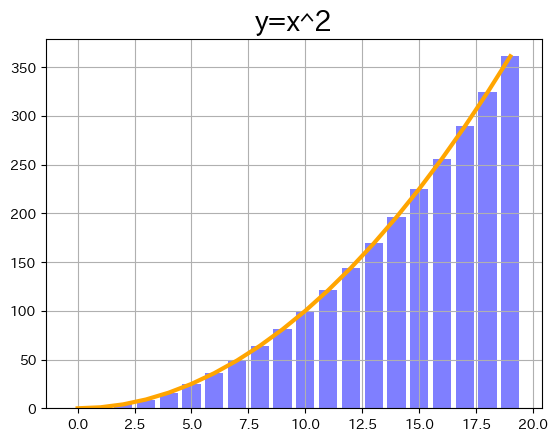

In [28]:
import matplotlib.pyplot as plt

# y = x^2のグラフ
x = [i for i in range(20)]
y = [i**2 for i in x]
plt.plot(x, y, color='orange', lw=3) # ドットグラフ
plt.bar(x, y, color='blue', alpha=0.5) # 棒グラフ
plt.title('y=x^2', fontsize=20)
plt.grid()
plt.show()

['の', '。', 'て', '、', 'は', 'に', 'を', 'と', 'が', 'た']
[9194, 7486, 6868, 6772, 6420, 6243, 6071, 5508, 5337, 3988]


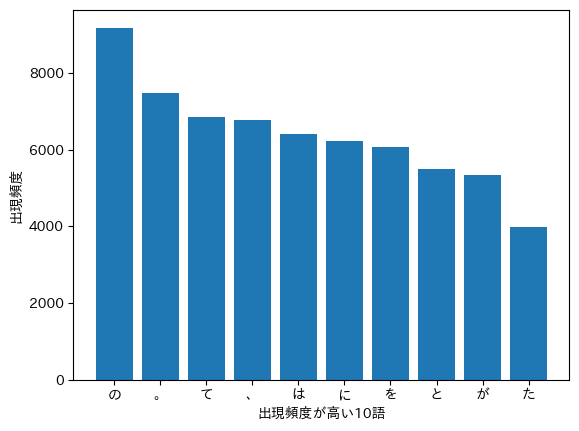

In [29]:
import matplotlib.pyplot as plt
import japanize_matplotlib # グラフに日本語が使えるようになる

# 出現頻度が高い10語を抽出
word_x = []
frequency_y = []
for tuple in word_frequency_list[:10]:
    word_x.append(tuple[0])
    frequency_y.append(tuple[1])
print(word_x)
print(frequency_y)

plt.bar(word_x, frequency_y)
plt.xlabel('出現頻度が高い10語')
plt.ylabel('出現頻度')
plt.show()

    zip(*タプル)で中にある2要素あるもの（タプルやリストなど）を2つのタプルに分けられる

In [77]:
tuple_list = [(1, 'one'), (2, 'two'), (3, 'three')]
list_list = [[1, 2], [3, 4], [5, 6]]
num, eng = zip(*tuple_list)
num1, num2 = zip(*list_list)
print(num, eng)
print(num1, num2)

(1, 2, 3) ('one', 'two', 'three')
(1, 3, 5) (2, 4, 6)


    plt.savefig(パス)でできたグラフは保存する

[('の', 9194), ('。', 7486), ('て', 6868), ('、', 6772), ('は', 6420), ('に', 6243), ('を', 6071), ('と', 5508), ('が', 5337), ('た', 3988)]
('の', '。', 'て', '、', 'は', 'に', 'を', 'と', 'が', 'た') (9194, 7486, 6868, 6772, 6420, 6243, 6071, 5508, 5337, 3988)


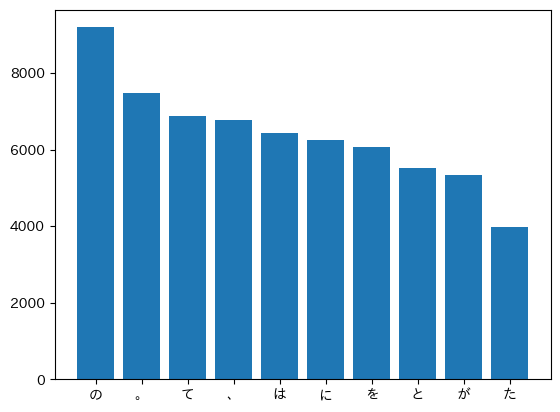

In [53]:
print(word_frequency_list[:10])
letter, cnt = zip(*word_frequency_list[:10])
print(letter, cnt)
plt.bar(letter, cnt)
plt.savefig('./work/a.png')
plt.show()

<h2 id="37-猫と共起頻度の高い上位10語">37. 「猫」と共起頻度の高い上位10語</h2>
<p>「猫」とよく共起する（共起頻度が高い）10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．</p>


共起
* 共起とはある単語同士が同じ文で使われること
* 共起頻度は同じ文内に出現する回数とする

すべての形態素に対して共起頻度を求める場合

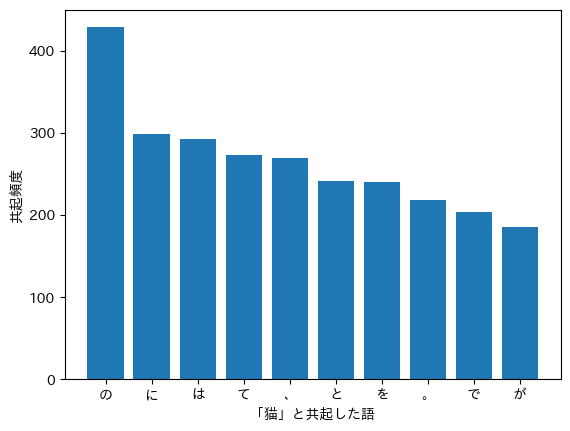

In [13]:
# defaultdictを用いて辞書の初期化の手間を省く
from collections import defaultdict
collocation_neko_dict = defaultdict(int)
neko = '猫'

# neko.txt から1文ずつ呼んで、猫が入っていたらその文を分かち書きして、それぞれの単語が共起しているとみなす
import MeCab
wakati = MeCab.Tagger("-Owakati")
with open('data/neko.txt') as f:
    # テキストを1文ずつ読む
    for line in f:
        line = line.rstrip() # 改行を消す
        if '猫' in line: # 文の中に「猫」がいるかを調べる
            words = wakati.parse(line).split() # 分かち書きしてそれぞれの形態素をリストへ入れる
            # それぞれの形態素を辞書に追加
            for word in words:
                # 猫ははじく
                if word == '猫':
                    continue
                collocation_neko_dict[word] += 1
# 共起頻度でソートする
collocation_neko_mostcommon = sorted(collocation_neko_dict.items(), reverse=True, key=lambda x:x[1])

# グラフで表示
import matplotlib.pyplot as plt
import japanize_matplotlib
coword_x = []
cofrequncy_y = []
# 上から10個だけ抽出
for cnm in collocation_neko_mostcommon[:10]:
    coword_x.append(cnm[0])
    cofrequncy_y.append(cnm[1])
plt.bar(coword_x, cofrequncy_y)
plt.xlabel('「猫」と共起した語')
plt.ylabel('共起頻度')
plt.show() 

名詞、形容詞、動詞の中で2文字以上の単語の共起頻度を求める場合

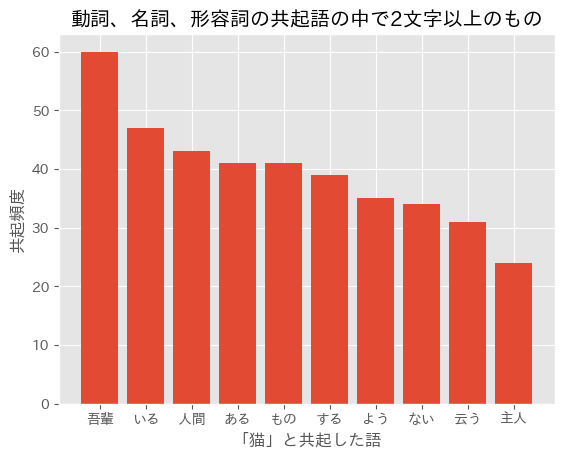

In [70]:
# defaultdictを用いて辞書の初期化の手間を省く
from collections import defaultdict
collocation_neko_dict = defaultdict(int)
neko = '猫'

# neko.txt から1文ずつ呼んで、猫が入っていたらその文を形態素解析して、名詞と形容詞と動詞が共起しているとみなす
import MeCab, ipadic, re
mecab = MeCab.Tagger(ipadic.MECAB_ARGS)
with open('data/neko.txt') as fr:
    repattern = re.compile(r'(.*?)\t(.*?)\,.*')
    # テキストを1文ずつ読む
    for line in fr:
        line = line.rstrip() # 改行を消す
        if '猫' in line: # 文の中に「猫」がいるかを調べる
            mecab_text = mecab.parse(line)

            # 1行ずつ読みたいのでファイルに一旦書く
            with open('src/temp.txt', 'w') as fw:
                fw.write(mecab_text)
            # そして書いたファイルを読む
            with open('src/temp.txt') as ftemp:
                # 形態素の表層語と品詞を抜き出す
                for mecab_line in ftemp:
                    match = repattern.match(mecab_line)
                    if match:
                        surfase = match.group(1)
                        pos = match.group(2)
                        # 猫ははじく, 1文字もつまんないのではじいてみた
                        if surfase == "猫" or len(surfase) == 1:
                            continue
                        # 品詞が名詞と形容詞と動詞のときのみ辞書に追加
                        if pos == '名詞' or pos == '動詞' or pos == '形容詞':
                            collocation_neko_dict[surfase] += 1

# 共起頻度でソートする
collocation_neko_mostcommon = sorted(collocation_neko_dict.items(), reverse=True, key=lambda x:x[1])

# グラフで表示
import matplotlib.pyplot as plt
import japanize_matplotlib
coword_x = []
cofrequncy_y = []
# 上から10個だけ抽出
for cnm in collocation_neko_mostcommon[:10]:
    coword_x.append(cnm[0])
    cofrequncy_y.append(cnm[1])
# coword_x, cofrequncy_y = zip(*collocation_neko_mostcommon[:10]) # zip*で分解

plt.bar(coword_x, cofrequncy_y) # 棒グラフ
plt.title('動詞、名詞、形容詞の共起語の中で2文字以上のもの')
plt.xlabel('「猫」と共起した語')
plt.ylabel('共起頻度')
plt.show() 

<h2 id="38-ヒストグラム">38. ヒストグラム</h2>
<p>単語の出現頻度のヒストグラムを描け．ただし，横軸は出現頻度を表し，1から単語の出現頻度の最大値までの線形目盛とする．縦軸はx軸で示される出現頻度となった単語の異なり数（種類数）である．</p>


ヒストグラムの最後の棒が重なるのはどうにかできる？  
→ binsオプションを少なくすればうまく表示される！

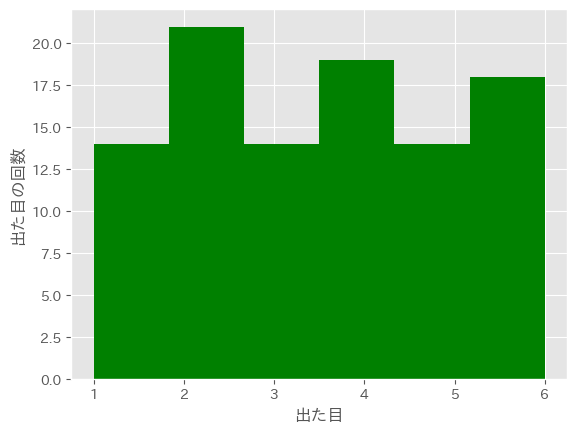

In [63]:
# ヒストグラムの確認
import matplotlib.pyplot as plt
import japanize_matplotlib
from random import randint

# サイコロをランダムに100回降ったときの出た目の回数
x = [randint(1, 6) for i in range(100)]
plt.style.use('ggplot') # いい感じの背景色とgridを引いてくれる
plt.hist(x, bins=6, color='g') # binsが6よりも大きいと表示が変になるので注意
plt.xlabel('出た目')
plt.ylabel('出た目の回数')
plt.show()

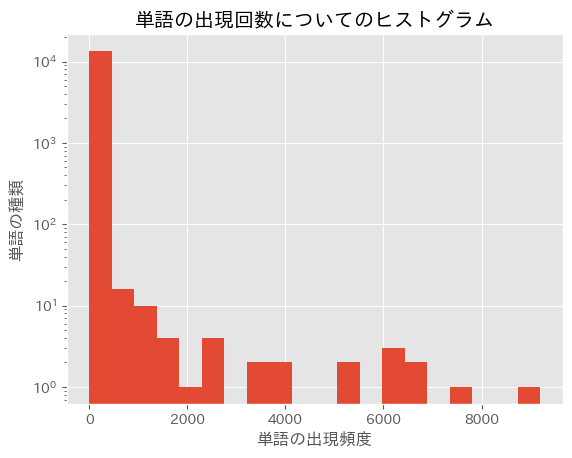

In [64]:
import matplotlib.pyplot as plt
import japanize_matplotlib

# 単語の頻度のみが入ったリスト
frequency = [wfl[1] for wfl in word_frequency_list]
# word, frequency_y = zip(*word_frequency_list) # zip*で分解

plt.hist(frequency, bins=20) # ヒストグラム
plt.xlabel('単語の出現頻度')
plt.ylabel('単語の種類')
plt.yscale('log') # 見づらいのでy軸を対数スケールにする
plt.title('単語の出現回数についてのヒストグラム')
plt.show()

<h2 id="39-zipfの法則">39. Zipfの法則</h2>
<p>単語の出現頻度順位を横軸，その出現頻度を縦軸として，両対数グラフをプロットせよ．</p>


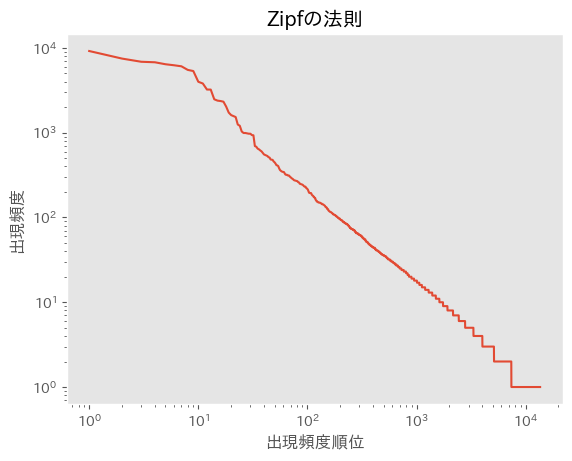

In [74]:
# 順位はインデックスで良い
index_x = [i+1 for i in range(len(word_frequency_list))]
frequency_y = [wfl[1] for wfl in word_frequency_list]
# word, frequency_y = zip(*word_frequency_list) # zip*で分解

import matplotlib.pyplot as plt
import japanize_matplotlib
plt.plot(index_x, frequency_y) # 折れ線グラフ
plt.xlabel('出現頻度順位')
plt.ylabel('出現頻度')
plt.title('Zipfの法則')
# 両対数にする
# plt.xscale('log')
# plt.yscale('log')
plt.loglog()
plt.grid()
plt.show()

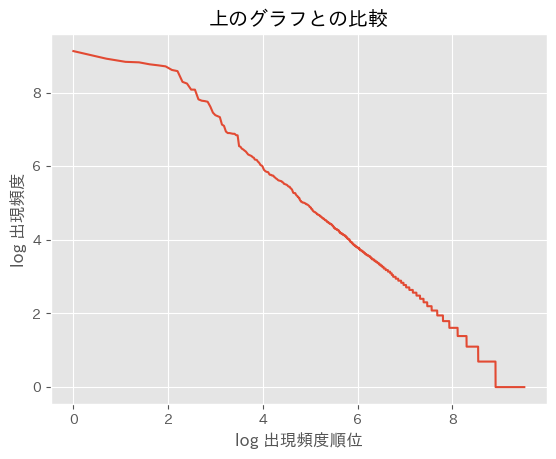

In [18]:
# 元データにログをとっても同じ形のグラフになる！
import math
index_x = [math.log(i+1) for i in range(len(word_frequency_list))]
frequency_y = [math.log(wfl[1]) for wfl in word_frequency_list]
# word, frequency_y = zip(*word_frequency_list) # zip*で分解

import matplotlib.pyplot as plt
import japanize_matplotlib
plt.plot(index_x, frequency_y) # 折れ線グラフ
plt.xlabel('log 出現頻度順位')
plt.ylabel('log 出現頻度')
plt.title('上のグラフとの比較')
# 両対数にするのはパス！
# plt.xscale('log')
# plt.yscale('log')
plt.show()

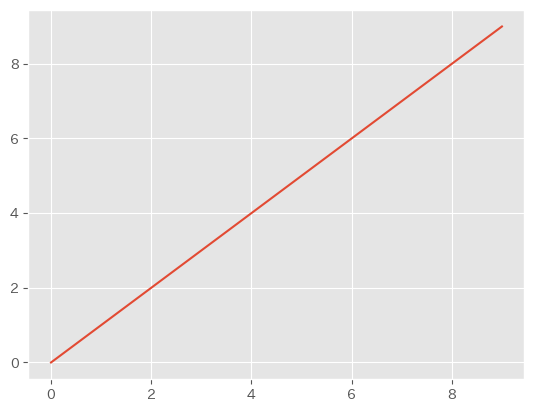

In [72]:
x = [i for i in range(10)]
y = [i for i in range(15)]
plt.plot(x, y)